In [1]:
from hicmatrix import HiCMatrix as hm
from hicmatrix.lib import MatrixFileHandler
import numpy as np
import pandas as pd
from scipy import stats, sparse
import bottleneck
from scipy.stats import mannwhitneyu
import h5py


SRP_name = 'aggregates'
resolution = '1kbp_raw' 
species= 'mouse'


def calc_auroc (df_trial,predicted_score='predicted_score'):
    df_trial = df_trial.sort_values(by=[predicted_score], ascending=False)
    rank_abs = lambda x: stats.rankdata(x)
    predicts2 = np.apply_along_axis(rank_abs, 0, df_trial[predicted_score].values)
    df_trial['p'] = [y if x==1 else 0 for x,y in zip(df_trial['true_pos'], predicts2)]
    #print (df_trial['p'].sum())
    if df_trial['true_neg'].sum() == 0 or df_trial['true_pos'].sum() == 0:
        return np.nan
    else:
        return (((df_trial['p'].sum() /df_trial['true_pos'].sum() )- (df_trial['true_pos'].sum() + 1)/2)) / df_trial['true_neg'].sum()




INFO:numexpr.utils:Note: detected 192 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
INFO:numexpr.utils:Note: NumExpr detected 192 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [2]:
cell_type = 'L2/3 IT'

In [7]:
cell_type_name = cell_type.replace('/', "_")

In [8]:
cell_type_name

'L2_3 IT'

In [2]:
exp_file_path=f'/grid/gillis/data/lohia/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/spr/hic_gene_corr_inter_excluding_intra_chrom_pairs_hicexp.h5'
jac_sim_spr = hm.hiCMatrix(exp_file_path)
all_genes_spr = [x[3].decode() for x in jac_sim_spr.cut_intervals]
df_jac_corr = pd.DataFrame(jac_sim_spr.matrix.toarray() ,  index=all_genes_spr, columns = all_genes_spr)
  

input_path=f'/grid/gillis/data/lohia/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/'
bins_bed = pd.read_csv(f'{input_path}/all_bins.bed', names=['chr', 'start', 'end', 'bin_id'])
bins_bed['bin_id'] = bins_bed.index
  
chr_list = bins_bed.drop_duplicates(subset=['chr'])['chr'].tolist()
chrom_index_list = {}
for chrom in chr_list:
      st = bins_bed[bins_bed['chr'] == chrom]['bin_id'].tolist()[0]
      en = bins_bed[bins_bed['chr'] == chrom]['bin_id'].tolist()[-1]
      chrom_index_list[chrom] = list(range(st, en+1))
gene_bed = pd.read_csv(f'{input_path}/all_gene.bed', names=['chr', 'start_bin', 'end_bin', 'gene'])





In [3]:
marker_list = pd.read_csv('/grid/gillis/data/lohia/hi_c_data_processing/notebooks/metamarkers/biccn_cluster_markers.csv')

all_markers_df = []
for marker_type in ['class', 'subclass', 'cluster']:
	marker_list = pd.read_csv(f'/grid/gillis/data/lohia/hi_c_data_processing/notebooks/metamarkers/biccn_{marker_type}_markers.csv')
	all_markers_df.append(marker_list)

marker_list = pd.concat(all_markers_df)
marker_list = marker_list.drop_duplicates(subset=['gene'])
df_ensg_name = pd.read_csv('/grid/gillis/data/lohia/hi_c_data_processing/genomes_jlee/mouse_geneid_symbol.txt',sep='\t', names=['gene_id', 'gene'])
#df_ensg_name['gene'] = df_ensg_name['gene'].str.upper()
marker_list = marker_list.merge(df_ensg_name.drop_duplicates(subset=['gene']), right_on='gene', left_on='gene') 
#df_ensg_name = pd.read_csv('/grid/gillis/data/lohia/hi_c_data_processing/genomes_jlee/ensg_geneid_symbol.csv', sep='\t')[['Ensembl_gene_identifier', 'Symbol']]
#marker_list = marker_list.merge(df_ensg_name.drop_duplicates(), right_on='Symbol', left_on='gene') 
#marker_list = marker_list.drop_duplicates(subset=['Ensembl_gene_identifier'])
marker_list = marker_list.drop_duplicates(subset=['gene_id'])


/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (15,16) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [4]:
with h5py.File(f'{input_path}/hic_gene_gw_none_by_allbins_none.h5', 'r') as hf:
        tot_g = (list(hf.keys()))

#all_background_markers = list(set(all_genes_spr) -  set(marker_list['Ensembl_gene_identifier'].tolist())) + marker_list['Ensembl_gene_identifier'].tolist()
all_background_markers = marker_list['gene_id'].tolist()



In [5]:
marker_contacts_list_inter = []

gene_list = []
with h5py.File(f'/grid/gillis/data/lohia/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/hic_gene_gw_none_by_allbins_none.h5', 'r') as hf:
                   
                   for key in all_background_markers:
                    if key in tot_g:
                            gene_list.append(key)
                            gene_chrom = gene_bed[gene_bed['gene'] == key]['chr'].values[0]
                            #which ever chrom the gene falls into, those bins should be nan
                            my_data = hf[key][()]
                            my_data = my_data.astype('float32')
                            my_data[chrom_index_list[gene_chrom]] = np.nan
                            marker_contacts_list_inter.append(my_data)
                            

In [6]:
my_data = np.array(marker_contacts_list_inter)

In [7]:
df_max_gene_inter_by_bins = pd.DataFrame(my_data, index=gene_list, columns = bins_bed['bin_id'].tolist())

df_max_gene_inter_by_bins_sum = df_max_gene_inter_by_bins.sum().reset_index()

df_max_gene_inter_by_bins_sum_mean = df_max_gene_inter_by_bins.mean().reset_index()

In [ ]:
outfile_name = f'/grid/gillis/data/lohia/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/background_sum.csv'
df_max_gene_inter_by_bins_sum.to_csv(outfile_name, index=False)
outfile_name = f'/grid/gillis/data/lohia/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/background_mean.csv'
df_max_gene_inter_by_bins_sum_mean.to_csv(outfile_name, index=False)


In [24]:
import os
number_of_genes_list = [200]
marker_level_list = ['class', 'subclass', 'cluster']

for number_of_genes in number_of_genes_list:
    for marker_level in marker_level_list:
        
        marker_list = pd.read_csv(f'/grid/gillis/data/lohia/hi_c_data_processing/notebooks/metamarkers/biccn_{marker_type}_markers.csv')
        df_ensg_name = pd.read_csv('/grid/gillis/data/lohia/hi_c_data_processing/genomes_jlee/mouse_geneid_symbol.txt',sep='\t', names=['gene_id', 'gene'])
        #df_ensg_name['gene'] = df_ensg_name['gene'].str.upper()
        marker_list = marker_list.merge(df_ensg_name.drop_duplicates(subset=['gene']), right_on='gene', left_on='gene') 

        #marker_list = pd.read_csv(f'/grid/gillis/data/lohia/hi_c_data_processing/notebooks/metamarkers/{species}/{marker_level}_markers_top1000.csv.gz', skiprows=1)
        #df_ensg_name = pd.read_csv('/grid/gillis/data/lohia/hi_c_data_processing/genomes_jlee/ensg_geneid_symbol.csv', sep='\t')[['Ensembl_gene_identifier', 'Symbol']]
        #marker_list = marker_list.merge(df_ensg_name.drop_duplicates(), right_on='Symbol', left_on='gene') 
        marker_list = marker_list[marker_list['gene_id'].isin(all_genes_spr)]
        #marker_list = marker_list[marker_list['rank'] < number_of_genes]
        all_cell_types = marker_list.drop_duplicates(['cell_type'])['cell_type'].tolist()
        df2_list = []
                    

                
        for group2 in all_cell_types:
                df2_list.append(marker_list[marker_list['cell_type']==group2].sort_values(by=['rank']).head(number_of_genes))

        marker_list=pd.concat(df2_list)

        marker_table = marker_list.pivot_table(index='gene_id', columns='cell_type', values='rank', aggfunc='sum')

        marker_table.fillna(0, inplace=True)
                    
        marker_table[marker_table != 0] = 1

        all_markers = marker_table.index.tolist()
                    


        marker_list = pd.read_csv(f'/grid/gillis/data/lohia/hi_c_data_processing/notebooks/metamarkers/biccn_{marker_type}_markers.csv')
        marker_list_types = marker_list.drop_duplicates(subset=['cell_type'])['cell_type'].tolist()   
        marker_list_groups = marker_list.drop_duplicates(subset=['cell_type'])['group'].tolist()   
        df_list_mean = []

        cell_type_list_order = []
        


        for group, cell_type in zip(marker_list_groups, marker_list_types):
            
            
            marker_genes_group = marker_table[marker_table[cell_type] == 1].index.tolist()

            df_tmp = df_max_gene_inter_by_bins.loc[marker_genes_group, :].mean(skipna=True).reset_index()

            df_tmp= df_tmp.set_index('index')
            df_tmp.rename(columns = {0:'mean_cell_type'}, inplace = True)

            d2 = df_tmp[['mean_cell_type']].T
            cell_type_list_order.append(cell_type)
            #d2['cell_type'] = cell_type
            #d2['subclass'] = group
            #d2['class'] = class_dict[group]
            
            df_list_mean.append(d2)
            #print (cell_type)
            
        df_concat_list_mean_nn = pd.concat(df_list_mean)
        column_list = df_concat_list_mean_nn.columns.tolist()
        print (number_of_genes)

        from umap import UMAP
        import plotly.express as px

        df = df_concat_list_mean_nn.dropna(axis=1)


        features = df

        umap_2d = UMAP(n_components=2, init='random', random_state=0)


        proj_2d = umap_2d.fit_transform(features)


        j = df_concat_list_mean_nn.to_numpy()
        
        

        outfile_name = f'/grid/gillis/data/lohia/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/{marker_level}_{number_of_genes}_contacts.h5'
        
        if os.path.isfile(outfile_name):
            os.remove(outfile_name)
        
        with h5py.File(outfile_name, 'a') as hf:
                            


            hf.create_dataset('type_contacts',data=j)
            hf.create_dataset('type_list',data=cell_type_list_order)
            hf.create_dataset('column_list',data=column_list)
            

            

        outfile_name = f'/grid/gillis/data/lohia/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/{marker_level}_{number_of_genes}_proj_2d.h5'
        
        if os.path.isfile(outfile_name):
            os.remove(outfile_name)
        with h5py.File(outfile_name, 'a') as hf:
                            

            hf.create_dataset('proj_2d',data=proj_2d)
            hf.create_dataset('type_list',data=cell_type_list_order)
            

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (15,16) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (15,16) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


200


/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (15,16) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (15,16) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


200


/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (15,16) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (15,16) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


200


In [ ]:
import os
from scipy.stats import mannwhitneyu

number_of_genes_list = [200]
marker_level_list = ['class']

for number_of_genes in number_of_genes_list:
    for marker_level in marker_level_list:
        
        marker_list = pd.read_csv(f'/grid/gillis/data/lohia/hi_c_data_processing/notebooks/metamarkers/biccn_{marker_type}_markers.csv')
        df_ensg_name = pd.read_csv('/grid/gillis/data/lohia/hi_c_data_processing/genomes_jlee/mouse_geneid_symbol.txt',sep='\t', names=['gene_id', 'gene'])
        #df_ensg_name['gene'] = df_ensg_name['gene'].str.upper()
        marker_list = marker_list.merge(df_ensg_name.drop_duplicates(subset=['gene']), right_on='gene', left_on='gene') 

        #marker_list = pd.read_csv(f'/grid/gillis/data/lohia/hi_c_data_processing/notebooks/metamarkers/{species}/{marker_level}_markers_top1000.csv.gz', skiprows=1)
        #df_ensg_name = pd.read_csv('/grid/gillis/data/lohia/hi_c_data_processing/genomes_jlee/ensg_geneid_symbol.csv', sep='\t')[['Ensembl_gene_identifier', 'Symbol']]
        #marker_list = marker_list.merge(df_ensg_name.drop_duplicates(), right_on='Symbol', left_on='gene') 
        marker_list = marker_list[marker_list['gene_id'].isin(all_genes_spr)]
        #marker_list = marker_list[marker_list['rank'] < number_of_genes]
        all_cell_types = marker_list.drop_duplicates(['cell_type'])['cell_type'].tolist()
        df2_list = []
                    

                
        for group2 in all_cell_types:
                df2_list.append(marker_list[marker_list['cell_type']==group2].sort_values(by=['rank']).head(number_of_genes))

        marker_list=pd.concat(df2_list)

        marker_table = marker_list.pivot_table(index='gene_id', columns='cell_type', values='rank', aggfunc='sum')

        marker_table.fillna(0, inplace=True)
                    
        marker_table[marker_table != 0] = 1

        all_markers = marker_table.index.tolist()
                    


        marker_list = pd.read_csv(f'/grid/gillis/data/lohia/hi_c_data_processing/notebooks/metamarkers/biccn_{marker_type}_markers.csv')
        marker_list_types = marker_list.drop_duplicates(subset=['cell_type'])['cell_type'].tolist()   
        marker_list_groups = marker_list.drop_duplicates(subset=['cell_type'])['group'].tolist()   
        df_list_mean = []

        cell_type_list_order = []
        
        df_list_p_val = []

        for group, cell_type in zip(marker_list_groups, marker_list_types):
            
            
            marker_genes_group = marker_table[marker_table[cell_type] == 1].index.tolist()

            df_max_gene_whole_group_1 = df_max_gene_inter_by_bins.loc[marker_genes_group, :]
            df_max_gene_whole_group_2 = df_max_gene_inter_by_bins.loc[:, :]
            
            def addData(x):
                try:
                    U, p_val = mannwhitneyu(x.dropna().tolist(), df_max_gene_whole_group_2[x.name].dropna().tolist(), alternative="two-sided")
                    return p_val
                except:
                    return np.nan

            
            new_df = df_max_gene_whole_group_1.apply(addData)
            df_list_p_val.append(new_df)
            cell_type_list_order.append(cell_type)
            column_list = df_max_gene_whole_group_1.columns.tolist()
            j = new_df.to_numpy()
            outfile_name = f'/grid/gillis/data/lohia/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/{marker_level}_{number_of_genes}_{cell_type}_p_val.h5'
        
            if os.path.isfile(outfile_name):
                os.remove(outfile_name)

            with h5py.File(outfile_name, 'a') as hf:



                hf.create_dataset('type_contacts',data=j)
                hf.create_dataset('type_list',data=cell_type_list_order)
                hf.create_dataset('column_list',data=column_list)
            



/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (15,16) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [ ]:

        outfile_name = f'/grid/gillis/data/lohia/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/{marker_level}_{number_of_genes}_contacts.h5'
        

In [ ]:
        outfile_name = f'/grid/gillis/data/lohia/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/{marker_level}_{number_of_genes}_{cell_type}_p_val.h5'
        
        if os.path.isfile(outfile_name):
            os.remove(outfile_name)
        
        with h5py.File(outfile_name, 'a') as hf:
                            


            hf.create_dataset('type_contacts',data=j)
            hf.create_dataset('type_list',data=cell_type_list_order)
            hf.create_dataset('column_list',data=column_list)
            
            

In [ ]:

        outfile_name = f'/grid/gillis/data/lohia/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/{marker_level}_{number_of_genes}_contacts.h5'
        

In [259]:

# function to returns x+y
def addData(x, y):
    print (x.name)
    print ("a")
    print (x)
    return x + y
 
# import pandas and numpy library
import pandas as pd
import numpy as np
 
# list of tuples
matrix = [(1,2,3,4),
          (5,6,7,8,),
          (9,10,11,12),
          (13,14,15,16)
         ]
 
# Creating a Dataframe object
df = pd.DataFrame(matrix, columns = list('abcd'))
print (df)
# Applying a user defined function to each
# column which will add value in each
# column by given number
new_df = df.apply(addData, args = [1])
 
# Output
print(new_df)

    a   b   c   d
0   1   2   3   4
1   5   6   7   8
2   9  10  11  12
3  13  14  15  16
a
a
0     1
1     5
2     9
3    13
Name: a, dtype: int64
b
a
0     2
1     6
2    10
3    14
Name: b, dtype: int64
c
a
0     3
1     7
2    11
3    15
Name: c, dtype: int64
d
a
0     4
1     8
2    12
3    16
Name: d, dtype: int64
    a   b   c   d
0   2   3   4   5
1   6   7   8   9
2  10  11  12  13
3  14  15  16  17


In [38]:
marker_level='cluster'
number_of_genes=200

with h5py.File(f'/grid/gillis/data/lohia/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/{marker_level}_{number_of_genes}_proj_2d.h5', 'r') as hf:
                   
        proj_2d = hf['proj_2d'][()]
        type_list = hf['type_list'][()]
        

In [39]:
type_list 

array([b'L2/3 IT_1', b'L2/3 IT_2', b'L2/3 IT_3', b'L4/5 IT_1',
       b'L4/5 IT_2', b'L5 IT_1', b'L5 IT_2', b'L5 IT_3', b'L5 IT_4',
       b'L5 PT_1', b'L5 PT_2', b'L5 PT_3', b'L5 PT_4', b'L5/6 NP CT',
       b'L5/6 NP_1', b'L5/6 NP_2', b'L5/6 NP_3', b'L6 CT Cpa6',
       b'L6 CT Gpr139', b'L6 CT Grp', b'L6 CT Kit_1', b'L6 CT Kit_2',
       b'L6 CT Pou3f2', b'L6 IT_1', b'L6 IT_2', b'L6b Col6a1',
       b'L6b Kcnip1', b'L6b Ror1', b'L6b Shisa6_1', b'L6b Shisa6_2',
       b'Lamp5 Egln3_1', b'Lamp5 Egln3_2', b'Lamp5 Egln3_3',
       b'Lamp5 Lhx6', b'Lamp5 Pax6', b'Lamp5 Pdlim5_1', b'Lamp5 Pdlim5_2',
       b'Lamp5 Slc35d3', b'Pvalb Calb1_1', b'Pvalb Calb1_2',
       b'Pvalb Egfem1', b'Pvalb Gabrg1', b'Pvalb Gpr149',
       b'Pvalb Il1rapl2', b'Pvalb Kank4', b'Pvalb Reln', b'Pvalb Vipr2_1',
       b'Pvalb Vipr2_2', b'Sncg Calb1_1', b'Sncg Calb1_2',
       b'Sncg Col14a1', b'Sncg Npy2r', b'Sncg Slc17a8', b'Vip Sncg',
       b'Sst C1ql3_1', b'Sst C1ql3_2', b'Sst Calb2', b'Sst Crhr2_1',
     

In [48]:
    df_class = pd.read_csv('/grid/gillis/data/lohia/hi_c_data_processing/notebooks/metamarkers/biccn_cluster_markers.csv')

    class_dict = dict(zip(df_class.cell_type,df_class.group))
    
    
    subclass_list = [class_dict[x.decode()] for x in type_list.tolist()]
    
    df_class = pd.read_csv('/grid/gillis/data/lohia/hi_c_data_processing/notebooks/metamarkers/biccn_subclass_markers.csv')

    class_dict = dict(zip(df_class.cell_type,df_class.group))
    class_dict['L4/5 IT'] = 'Glutamatergic'
    class_dict['L5 PT'] = 'Glutamatergic'
    class_list = [class_dict[x] for x in subclass_list]
    

<AxesSubplot:>

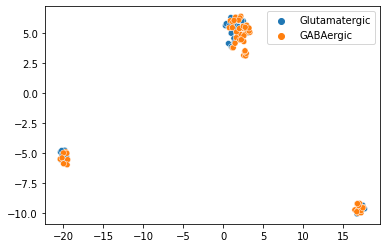

In [49]:
%matplotlib inline
import seaborn as sns
sns.scatterplot(x=proj_2d[:,0], y=proj_2d[:,1], hue=class_list)

In [56]:
marker_level='cluster'
number_of_genes=200

with h5py.File(f'/grid/gillis/data/lohia/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/{marker_level}_{number_of_genes}_contacts.h5', 'r') as hf:
                   
        my_data = hf['type_contacts'][()]
        type_list = hf['type_list'][()]
        column_list = hf['column_list'][()]




df_max_gene_inter_by_bins_tmp = pd.DataFrame(my_data, index=[x.decode() for x in type_list.tolist()], columns = column_list.tolist())
#df_max_gene_inter_by_bins['group'] = [x.decode() for x in type_list.tolist()]

In [57]:
df_concat_list_mean_nn_by_bins_normalized = df_max_gene_inter_by_bins_tmp.div(df_max_gene_inter_by_bins_sum_mean[0], axis=1)


<AxesSubplot:>

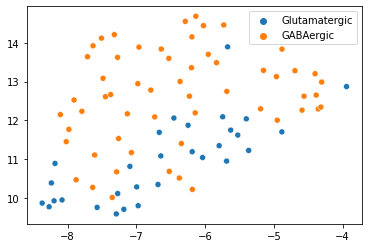

In [58]:
from umap import UMAP
import plotly.express as px

df = df_concat_list_mean_nn_by_bins_normalized.loc[:, :].dropna(axis=1)


#features = df
features = df




umap_2d = UMAP(n_components=2, init='random', random_state=0)




proj_2d = umap_2d.fit_transform(features)


%matplotlib inline
import seaborn as sns
sns.scatterplot(x=proj_2d[:,0], y=proj_2d[:,1], hue=class_list)

<AxesSubplot:>

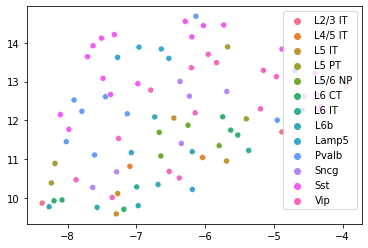

In [59]:
%matplotlib inline
import seaborn as sns
sns.scatterplot(x=proj_2d[:,0], y=proj_2d[:,1], hue=subclass_list)

In [60]:
fig_2d = px.scatter(
    proj_2d, x=0, y=1,
    color=subclass_list, labels={'color': 'group'}, color_discrete_sequence=["red", "green", "blue", "goldenrod", "magenta", "tomato", "black", "lime", "cyan", "teal", "aqua", "lime", "chocolate", "violet", "black", "lightcoral", "yellowgreen", "orchid", "grey"]
)


fig_2d.show()


(0.0, 5.0)

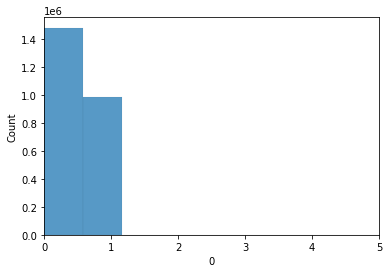

In [79]:
ax=sns.histplot(df_max_gene_inter_by_bins_sum_mean[0], bins=900)
ax.set_xlim([0,5])

In [ ]:
for filename, col_names, filepath in zip(['GSE126074', 'BICCN2', 'GSE111586', 'GSE123576', 'GSE1303990'], [['OT','EX', 'IN', 'NA'], ['AC','EX','IN','OG','OT'], ['OT','EX', 'IN'], ['OT','EX', 'IN'], ['OT','EX', 'IN']], ['output_GSE126074_gene_global_index__all_scanpy_obj_clust_ave_celltype.bed', 'output_BICCN2_gene_global_index__all_scanpy_obj_clust_ave_celltype.bed','output_GSE111586_gene_global_index_5000__all_scanpy_obj_clust_ave_celltype.bed', 'output_GSE123576_gene_global_index_1000__all_scanpy_obj_clust_ave_celltype.bed', 'output_GSE1303990_gene_global_index_5000__all_scanpy_obj_clust_ave_celltype.bed']):

    

    atac_file_path= f"/grid/gillis/data/lohia/ATAC_Risa/celltype/{filepath}"
    
    comple_col = ['chr', 'start', 'end']
    
    comple_col.extend(col_names)
    
    print (comple_col)

    df = pd.read_csv(atac_file_path, sep='\t|,', skiprows=1, names=comple_col)
    
    print (df)


In [61]:
for filename, col_names, filepath in zip(['BICCN2'], [['AC','EX','IN','OG','OT']], ['output_BICCN2_gene_global_index__all_scanpy_obj_clust_ave_celltype.bed']):

    

    atac_file_path= f"/grid/gillis/data/lohia/ATAC_Risa/celltype/{filepath}"
    
    comple_col = ['chr', 'start', 'end']
    
    comple_col.extend(col_names)
    
    print (comple_col)

    df = pd.read_csv(atac_file_path, sep='\t|,', skiprows=1, names=comple_col)
    
    print (df)

['chr', 'start', 'end', 'AC', 'EX', 'IN', 'OG', 'OT']


<ipython-input-61-87f58c16cc99>:13: ParserWarning:

Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.



        chr      start        end        AC        EX        IN        OG  \
0         X    3052001    3053000  0.000139  0.000000  0.000000  0.000000   
1         X    3053001    3054000  0.000139  0.000000  0.000000  0.000000   
2         X    3054001    3055000  0.000139  0.000000  0.000000  0.000000   
3         X    3057001    3058000  0.000277  0.000000  0.000000  0.000000   
4         X    3058001    3059000  0.000139  0.000000  0.000000  0.000000   
...      ..        ...        ...       ...       ...       ...       ...   
2466671   8  129297001  129298000  0.000139  0.000923  0.000336  0.000000   
2466672   8  129298001  129299000  0.000139  0.001160  0.000224  0.000169   
2466673   8  129299001  129300000  0.000139  0.001705  0.000224  0.000169   
2466674   8  129300001  129301000  0.000832  0.001539  0.000783  0.000253   
2466675   8  129301001  129302000  0.000139  0.000308  0.000000  0.000000   

               OT  
0        0.000000  
1        0.000000  
2        0.0000

In [65]:
    df['start_bin'] = df['start'] / 1000


    df['end_bin'] = df['end'] / 1000

    df['start_bin'] = df['start_bin'].astype(int)
    df['end_bin'] = df['end_bin'].astype(int)
    
    
    df['start_bin'] = df['start_bin']*1000
    df['end_bin'] = df['end_bin']*1000
   

    df_atac = df.groupby(['chr','start_bin'])[col_names].sum().reset_index()
    
    df_atac['chr'] = df_atac['chr'].astype('str')
    df_atac['chr'] = 'chr' + df_atac['chr']

    df_atac['start_bin'] = df_atac['chr'] + '_'+df_atac['start_bin'].astype(str) 

In [66]:
df_atac

chr       start_bin        AC        EX        IN        OG  \
0        chr1    chr1_3000000  0.000139  0.000213  0.000112  0.000169   
1        chr1    chr1_3001000  0.000139  0.000166  0.000336  0.000000   
2        chr1    chr1_3002000  0.000000  0.000047  0.000000  0.000000   
3        chr1    chr1_3003000  0.000277  0.000473  0.000560  0.000338   
4        chr1    chr1_3004000  0.000139  0.000237  0.000783  0.000338   
...       ...             ...       ...       ...       ...       ...   
2466671  chrX  chrX_170849000  0.000139  0.000000  0.000000  0.000000   
2466672  chrX  chrX_170850000  0.000139  0.000000  0.000000  0.000000   
2466673  chrX  chrX_170856000  0.000139  0.000000  0.000000  0.000000   
2466674  chrX  chrX_170859000  0.000000  0.000024  0.000000  0.000084   
2466675  chrX  chrX_170881000  0.000000  0.000095  0.000224  0.000169   

               OT  
0        0.000091  
1        0.000182  
2        0.000000  
3        0.000820  
4        0.000547  
...           ...  
2466671  0.000000  
2466672  0.000000  
2466673  0.000000  
2466674  0.000000  
2466675  0.000182  

[2466676 rows x 7 columns]

In [68]:

input_path=f'/grid/gillis/data/lohia/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/'
bins_bed = pd.read_csv(f'{input_path}/all_bins.bed', names=['chr', 'start', 'end', 'bin_id'])
bins_bed['bin_id'] = bins_bed.index
bins_bed['pos'] = bins_bed['chr'] + '_' + bins_bed['start'].astype('str')

In [64]:
df_max_gene_inter_by_bins_tmp

0        1        2        3        4        5        6        \
L2/3 IT_1           0.0      0.0      0.0      0.0      0.0      0.0      0.0   
L2/3 IT_2           0.0      0.0      0.0      0.0      0.0      0.0      0.0   
L2/3 IT_3           0.0      0.0      0.0      0.0      0.0      0.0      0.0   
L4/5 IT_1           0.0      0.0      0.0      0.0      0.0      0.0      0.0   
L4/5 IT_2           0.0      0.0      0.0      0.0      0.0      0.0      0.0   
...                 ...      ...      ...      ...      ...      ...      ...   
Vip Mybpc1_2        0.0      0.0      0.0      0.0      0.0      0.0      0.0   
Vip Mybpc1_3        0.0      0.0      0.0      0.0      0.0      0.0      0.0   
Vip Serpinf1_1      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
Vip Serpinf1_2      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
Vip Serpinf1_3      0.0      0.0      0.0      0.0      0.0      0.0      0.0   

                7        8        9        ...  2462745  2462746  2462747  \
L2/3 IT_1           0.0      0.0      0.0  ...      0.0      0.0      0.0   
L2/3 IT_2           0.0      0.0      0.0  ...      0.0      0.0      0.0   
L2/3 IT_3           0.0      0.0      0.0  ...      0.0      0.0      0.0   
L4/5 IT_1           0.0      0.0      0.0  ...      0.0      0.0      0.0   
L4/5 IT_2           0.0      0.0      0.0  ...      0.0      0.0      0.0   
...                 ...      ...      ...  ...      ...      ...      ...   
Vip Mybpc1_2        0.0      0.0      0.0  ...      0.0      0.0      0.0   
Vip Mybpc1_3        0.0      0.0      0.0  ...      0.0      0.0      0.0   
Vip Serpinf1_1      0.0      0.0      0.0  ...      0.0      0.0      0.0   
Vip Serpinf1_2      0.0      0.0      0.0  ...      0.0      0.0      0.0   
Vip Serpinf1_3      0.0      0.0      0.0  ...      0.0      0.0      0.0   

                2462748  2462749  2462750  2462751  2462752  2462753  2462754  
L2/3 IT_1           0.0      0.0      0.0      0.0      0.0      0.0      0.0  
L2/3 IT_2           0.0      0.0      0.0      0.0      0.0      0.0      0.0  
L2/3 IT_3           0.0      0.0      0.0      0.0      0.0      0.0      0.0  
L4/5 IT_1           0.0      0.0      0.0      0.0      0.0      0.0      0.0  
L4/5 IT_2           0.0      0.0      0.0      0.0      0.0      0.0      0.0  
...                 ...      ...      ...      ...      ...      ...      ...  
Vip Mybpc1_2        0.0      0.0      0.0      0.0      0.0      0.0      0.0  
Vip Mybpc1_3        0.0      0.0      0.0      0.0      0.0      0.0      0.0  
Vip Serpinf1_1      0.0      0.0      0.0      0.0      0.0      0.0      0.0  
Vip Serpinf1_2      0.0      0.0      0.0      0.0      0.0      0.0      0.0  
Vip Serpinf1_3      0.0      0.0      0.0      0.0      0.0      0.0      0.0  

[86 rows x 2462755 columns]

In [69]:
df_cre_1kb_end = df_atac.merge(bins_bed, left_on='start_bin', right_on='pos')

In [70]:
df_cre_1kb_end 

chr_x       start_bin        AC        EX        IN        OG  \
0        chr1    chr1_3000000  0.000139  0.000213  0.000112  0.000169   
1        chr1    chr1_3001000  0.000139  0.000166  0.000336  0.000000   
2        chr1    chr1_3002000  0.000000  0.000047  0.000000  0.000000   
3        chr1    chr1_3003000  0.000277  0.000473  0.000560  0.000338   
4        chr1    chr1_3004000  0.000139  0.000237  0.000783  0.000338   
...       ...             ...       ...       ...       ...       ...   
2321467  chr9  chr9_124491000  0.000139  0.000308  0.000000  0.000169   
2321468  chr9  chr9_124492000  0.000139  0.000213  0.000224  0.000084   
2321469  chr9  chr9_124493000  0.000000  0.000402  0.000224  0.000000   
2321470  chr9  chr9_124494000  0.000554  0.001539  0.000224  0.000338   
2321471  chr9  chr9_124495000  0.000139  0.000450  0.000112  0.000169   

               OT chr_y      start        end   bin_id             pos  
0        0.000091  chr1    3000000    3001000     3000    chr1_3000000  
1        0.000182  chr1    3001000    3002000     3001    chr1_3001000  
2        0.000000  chr1    3002000    3003000     3002    chr1_3002000  
3        0.000820  chr1    3003000    3004000     3003    chr1_3003000  
4        0.000547  chr1    3004000    3005000     3004    chr1_3004000  
...           ...   ...        ...        ...      ...             ...  
2321467  0.000273  chr9  124491000  124492000  1395042  chr9_124491000  
2321468  0.000091  chr9  124492000  124493000  1395043  chr9_124492000  
2321469  0.000000  chr9  124493000  124494000  1395044  chr9_124493000  
2321470  0.001185  chr9  124494000  124495000  1395045  chr9_124494000  
2321471  0.000091  chr9  124495000  124496000  1395046  chr9_124495000  

[2321472 rows x 12 columns]

In [81]:
df_max_gene_inter_by_bins_tmp

0        1        2        3        4        5        6        \
L2/3 IT_1           0.0      0.0      0.0      0.0      0.0      0.0      0.0   
L2/3 IT_2           0.0      0.0      0.0      0.0      0.0      0.0      0.0   
L2/3 IT_3           0.0      0.0      0.0      0.0      0.0      0.0      0.0   
L4/5 IT_1           0.0      0.0      0.0      0.0      0.0      0.0      0.0   
L4/5 IT_2           0.0      0.0      0.0      0.0      0.0      0.0      0.0   
...                 ...      ...      ...      ...      ...      ...      ...   
Vip Mybpc1_2        0.0      0.0      0.0      0.0      0.0      0.0      0.0   
Vip Mybpc1_3        0.0      0.0      0.0      0.0      0.0      0.0      0.0   
Vip Serpinf1_1      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
Vip Serpinf1_2      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
Vip Serpinf1_3      0.0      0.0      0.0      0.0      0.0      0.0      0.0   

                7        8        9        ...  2462745  2462746  2462747  \
L2/3 IT_1           0.0      0.0      0.0  ...      0.0      0.0      0.0   
L2/3 IT_2           0.0      0.0      0.0  ...      0.0      0.0      0.0   
L2/3 IT_3           0.0      0.0      0.0  ...      0.0      0.0      0.0   
L4/5 IT_1           0.0      0.0      0.0  ...      0.0      0.0      0.0   
L4/5 IT_2           0.0      0.0      0.0  ...      0.0      0.0      0.0   
...                 ...      ...      ...  ...      ...      ...      ...   
Vip Mybpc1_2        0.0      0.0      0.0  ...      0.0      0.0      0.0   
Vip Mybpc1_3        0.0      0.0      0.0  ...      0.0      0.0      0.0   
Vip Serpinf1_1      0.0      0.0      0.0  ...      0.0      0.0      0.0   
Vip Serpinf1_2      0.0      0.0      0.0  ...      0.0      0.0      0.0   
Vip Serpinf1_3      0.0      0.0      0.0  ...      0.0      0.0      0.0   

                2462748  2462749  2462750  2462751  2462752  2462753  2462754  
L2/3 IT_1           0.0      0.0      0.0      0.0      0.0      0.0      0.0  
L2/3 IT_2           0.0      0.0      0.0      0.0      0.0      0.0      0.0  
L2/3 IT_3           0.0      0.0      0.0      0.0      0.0      0.0      0.0  
L4/5 IT_1           0.0      0.0      0.0      0.0      0.0      0.0      0.0  
L4/5 IT_2           0.0      0.0      0.0      0.0      0.0      0.0      0.0  
...                 ...      ...      ...      ...      ...      ...      ...  
Vip Mybpc1_2        0.0      0.0      0.0      0.0      0.0      0.0      0.0  
Vip Mybpc1_3        0.0      0.0      0.0      0.0      0.0      0.0      0.0  
Vip Serpinf1_1      0.0      0.0      0.0      0.0      0.0      0.0      0.0  
Vip Serpinf1_2      0.0      0.0      0.0      0.0      0.0      0.0      0.0  
Vip Serpinf1_3      0.0      0.0      0.0      0.0      0.0      0.0      0.0  

[86 rows x 2462755 columns]

In [227]:
    df_class = pd.read_csv('/grid/gillis/data/lohia/hi_c_data_processing/notebooks/metamarkers/biccn_cluster_markers.csv')

    class_dict = dict(zip(df_class.cell_type,df_class.group))
    
    
    subclass_list = [class_dict[x.decode()] for x in type_list.tolist()]
    df_max_gene_inter_by_bins_tmp['subclass'] = [class_dict[x.decode()] for x in type_list.tolist()]
    
    df_class = pd.read_csv('/grid/gillis/data/lohia/hi_c_data_processing/notebooks/metamarkers/biccn_subclass_markers.csv')

    class_dict = dict(zip(df_class.cell_type,df_class.group))
    class_dict['L4/5 IT'] = 'Glutamatergic'
    class_dict['L5 PT'] = 'Glutamatergic'
    class_list = [class_dict[x] for x in subclass_list]
    df_max_gene_inter_by_bins_tmp['class'] = [class_dict[x] for x in df_max_gene_inter_by_bins_tmp['subclass'].tolist()]
    

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning:

Columns (15,16) have mixed types.Specify dtype option on import or set low_memory=False.



In [228]:
    group_max = []
    for groupname in ['Glutamatergic', 'GABAergic']:
        df_concat_vip = df_max_gene_inter_by_bins_tmp[df_max_gene_inter_by_bins_tmp["class"] == groupname].loc[:, :2462754].min().reset_index().set_index('index').T
        df_concat_vip['group'] = groupname
        group_max.append(df_concat_vip)

    df_group_max = pd.concat(group_max)
    
    

In [180]:
df_concat_list_mean_nn_by_bins_normalized

0   1   2   3   4   5   6   7   8   9  ...  2462747  2462748  \
L2/3 IT_1      NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ...      NaN      NaN   
L2/3 IT_2      NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ...      NaN      NaN   
L2/3 IT_3      NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ...      NaN      NaN   
L4/5 IT_1      NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ...      NaN      NaN   
L4/5 IT_2      NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ...      NaN      NaN   
...             ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ...      ...      ...   
Vip Mybpc1_2   NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ...      NaN      NaN   
Vip Mybpc1_3   NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ...      NaN      NaN   
Vip Serpinf1_1 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ...      NaN      NaN   
Vip Serpinf1_2 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ...      NaN      NaN   
Vip Serpinf1_3 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ...      NaN      NaN   

                2462749  2462750  2462751  2462752  2462753  2462754  \
L2/3 IT_1           NaN      NaN      NaN      NaN      NaN      NaN   
L2/3 IT_2           NaN      NaN      NaN      NaN      NaN      NaN   
L2/3 IT_3           NaN      NaN      NaN      NaN      NaN      NaN   
L4/5 IT_1           NaN      NaN      NaN      NaN      NaN      NaN   
L4/5 IT_2           NaN      NaN      NaN      NaN      NaN      NaN   
...                 ...      ...      ...      ...      ...      ...   
Vip Mybpc1_2        NaN      NaN      NaN      NaN      NaN      NaN   
Vip Mybpc1_3        NaN      NaN      NaN      NaN      NaN      NaN   
Vip Serpinf1_1      NaN      NaN      NaN      NaN      NaN      NaN   
Vip Serpinf1_2      NaN      NaN      NaN      NaN      NaN      NaN   
Vip Serpinf1_3      NaN      NaN      NaN      NaN      NaN      NaN   

                subclass          class  
L2/3 IT_1        L2/3 IT  Glutamatergic  
L2/3 IT_2        L2/3 IT  Glutamatergic  
L2/3 IT_3        L2/3 IT  Glutamatergic  
L4/5 IT_1        L4/5 IT  Glutamatergic  
L4/5 IT_2        L4/5 IT  Glutamatergic  
...                  ...            ...  
Vip Mybpc1_2         Vip      GABAergic  
Vip Mybpc1_3         Vip      GABAergic  
Vip Serpinf1_1       Vip      GABAergic  
Vip Serpinf1_2       Vip      GABAergic  
Vip Serpinf1_3       Vip      GABAergic  

[86 rows x 2462757 columns]

In [ ]:
ax=sns.histplot(df_max_gene_inter_by_bins_sum_mean[0], bins=900)
ax.set_xlim([0,5])

In [229]:
df_cre_tog = df_cre_1kb_end.set_index('bin_id').merge(df_group_max.set_index(['group']).T, left_on=df_cre_1kb_end.set_index('bin_id').index, right_on=df_group_max.set_index(['group']).T.index)



In [230]:
df_cre_tog['glu-gaba'] = df_cre_tog['Glutamatergic'] - df_cre_tog['GABAergic']

In [248]:
df_cre_tog_gaba = df_cre_tog[df_cre_tog['IN']==0]

In [249]:
df_cre_tog_gaba = df_cre_tog_gaba[(df_cre_tog_gaba['GABAergic']==0) | (df_cre_tog_gaba['Glutamatergic']==0)]

In [164]:
df_cre_tog_gaba['GABAergic'].mean() Glua zero

1.740383267402649

In [167]:
df_cre_tog_gaba['GABAergic'].mean() #Gaba zero

1.668292760848999

In [165]:
df_cre_tog_gaba['Glutamatergic'].mean() #Glua zero

1.3338593244552612

In [168]:
df_cre_tog_gaba['Glutamatergic'].mean() #Gaba zero

1.305026650428772

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



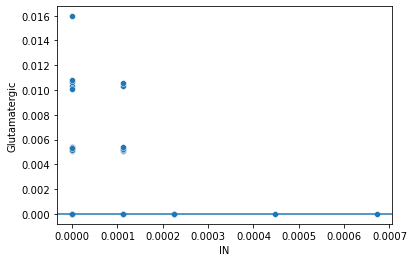

In [237]:
ax = sns.scatterplot(df_cre_tog_gaba['IN'], df_cre_tog_gaba['Glutamatergic'])
ax.axhline(0)

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



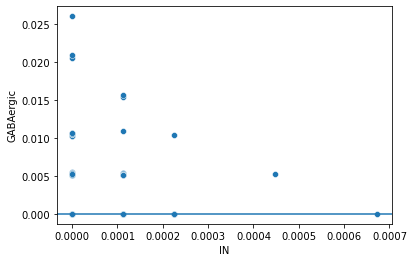

In [238]:
ax = sns.scatterplot(df_cre_tog_gaba['IN'], df_cre_tog_gaba['GABAergic'])
ax.axhline(0)

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



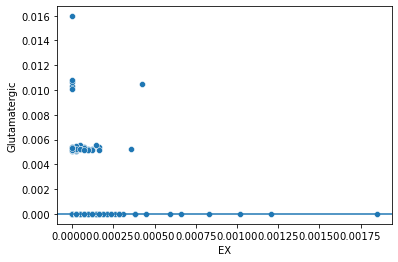

In [234]:
ax = sns.scatterplot(df_cre_tog_gaba['EX'], df_cre_tog_gaba['Glutamatergic'])
ax.axhline(0)

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



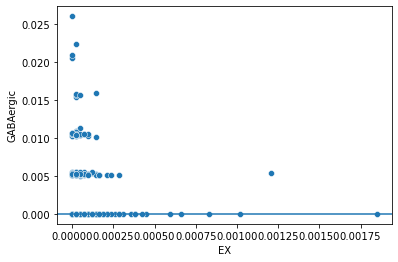

In [233]:
ax = sns.scatterplot(df_cre_tog_gaba['EX'], df_cre_tog_gaba['GABAergic'])
ax.axhline(0)

In [192]:
df_cre_tog_gaba

Empty DataFrame
Columns: [key_0, chr_x, start_bin, AC, EX, IN, OG, OT, chr_y, start, end, pos, Glutamatergic, GABAergic, glu-gaba, EX-IN]
Index: []

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



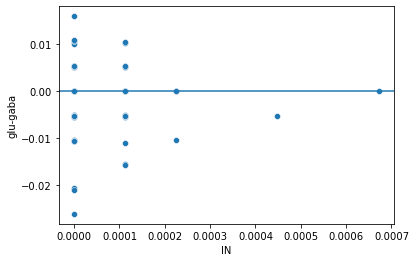

In [247]:
ax = sns.scatterplot(df_cre_tog_gaba['IN'], df_cre_tog_gaba['glu-gaba'])
ax.axhline(0)

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



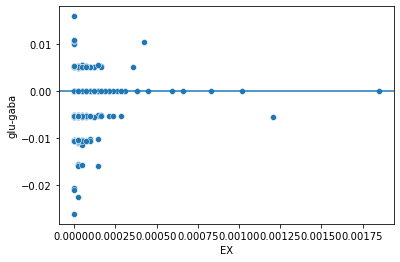

In [250]:
ax = sns.scatterplot(df_cre_tog_gaba['EX'], df_cre_tog_gaba['glu-gaba'])
ax.axhline(0)

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



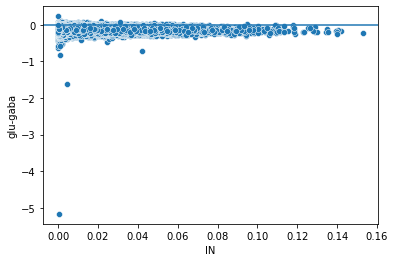

In [245]:
ax = sns.scatterplot(df_cre_tog['IN'], df_cre_tog['glu-gaba'])
ax.axhline(0)

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



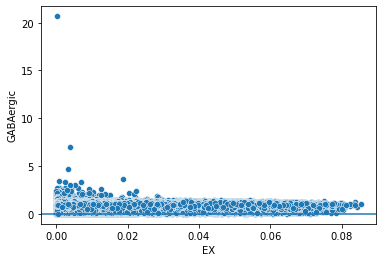

In [241]:
ax = sns.scatterplot(df_cre_tog['EX'], df_cre_tog['GABAergic'])
ax.axhline(0)

In [117]:
df_cre_tog['EX-IN'] = df_cre_tog['EX'] - df_cre_tog['IN']

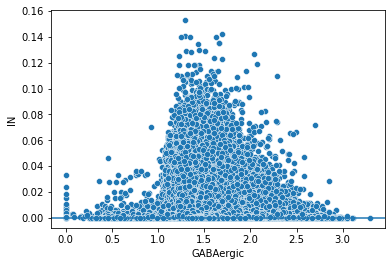

In [145]:
ax = sns.scatterplot(y=df_cre_tog_gaba['IN'], x=df_cre_tog_gaba['GABAergic'])
ax.axhline(0)

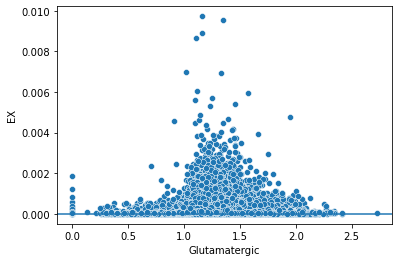

In [152]:
ax = sns.scatterplot(y=df_cre_tog_gaba['EX'], x=df_cre_tog_gaba['Glutamatergic'])
ax.axhline(0)

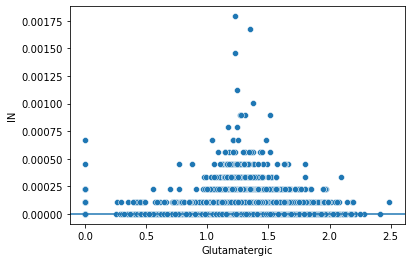

In [154]:
ax = sns.scatterplot(y=df_cre_tog_gaba['IN'], x=df_cre_tog_gaba['Glutamatergic'])
ax.axhline(0)

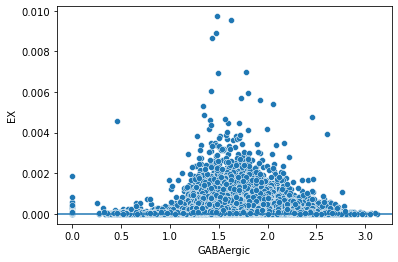

In [149]:
ax = sns.scatterplot(y=df_cre_tog_gaba['EX'], x=df_cre_tog_gaba['GABAergic'])
ax.axhline(0)

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



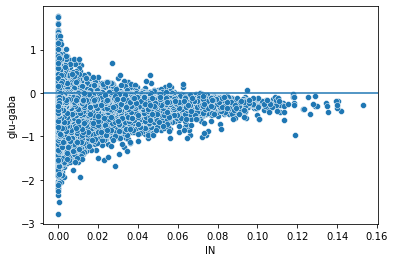

In [116]:
ax = sns.scatterplot(df_cre_tog['IN'], df_cre_tog['glu-gaba'])
ax.axhline(0)